RNN numba package
=================



## A few settings



### autoreload



In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

### project root



In [1]:
import os
import sys
# current_dir = os.path.dirname(os.path.abspath('__file__'))
# # Get parent directory (= the project root)
# project_root = os.path.join(current_dir, '..')
# # Append to system path
# sys.path.append(project_root)
# print(sys.path)

print("Python exe")
print(sys.executable)

Python exe
/home/leon/mambaforge/envs/dual_data/bin/python

### imports and setting up matplotlib



In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle as pkl

sns.set_context("poster")
sns.set_style("ticks")
plt.rc("axes.spines", top=False, right=False)
fig_path = '../figs/perf'
golden_ratio = (5**.5 - 1) / 2
width = 6
height = width * golden_ratio

matplotlib.rcParams['figure.figsize'] = [width, height]

matplotlib.rcParams['lines.markersize'] = 5
%matplotlib inline
%config InlineBackend.figure_format = 'png'

a test figure
2

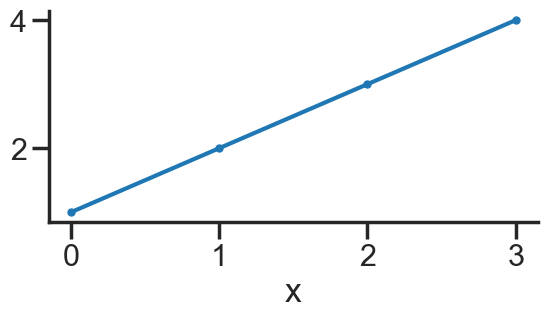

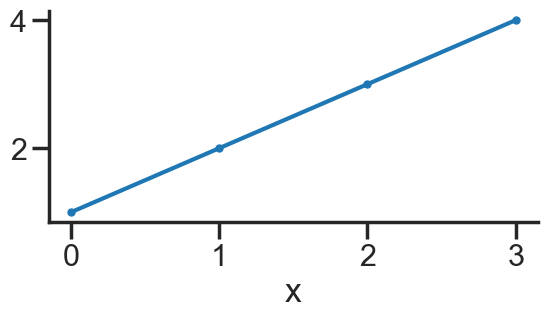

In [1]:
print('a test figure')
plt.figure()
plt.plot([1,2,3,4], '-o')
plt.xlabel('x')
# plt.show()

plt.figure()
plt.plot([1,2,3,4], '-o')
plt.xlabel('x')
# plt.show()

1+1

## Continuous Bump Attractor Model



### imports



In [1]:
import sys
sys.path.insert(0, '/home/leon/tmp/rnn_numba') # put here the path to the repo
from src.model.rate_model import Network

### Single trial



#### Simulation



To run a simulation, first we need to define a network model.
The class Network takes two arguments:

1.  the name of the configuration file that defines the model. 
    This file is well detailed (check config<sub>bump.yml</sub> or config<sub>EI.yml</sub>)
2.  the name of the output file that will contain the simulation data.
    The model writes all relevant data to a single dataframe stored in an h5 format



In [1]:
REPO_PATH = "/home/leon/tmp/rnn_numba"
model = Network('config_bump.yml', 'bump', REPO_PATH, VERBOSE=1)

Loading config from /home/leon/tmp/rnn_numba/conf/config_bump.yml
Saving to /home/leon/tmp/rnn_numba/data/simul/bump.h5
Jab [[-2.75]]
SIGMA [[0.]]
KAPPA [[0.4]]
Iext [14.]

Then one just runs the model with



In [1]:
model.run()

#+begin_example
  Generating matrix Cij
  random connectivity
  with all to all cosine structure
  Saving matrix to /home/leon/tmp/rnn_numba/data/matrix/Cij.npy
  Parameters:
  N 1000 Na [1000] K 1.0 Ka [1.]
  Iext [14.] Jab [-2.75]
  KAPPA [[0.4]] SIGMA [[0.]]
  MF Rates: [5.09090909]
  Running simulation
  times (s) 0.5 rates (Hz) [2.14]
  times (s) 1.0 rates (Hz) [2.16]
  STIM ON
  times (s) 1.5 rates (Hz) [6.28]
  STIM OFF
  times (s) 2.0 rates (Hz) [5.88]
  times (s) 2.5 rates (Hz) [5.84]
  CUE ON
  times (s) 3.0 rates (Hz) [5.88]
  CUE OFF
  times (s) 3.5 rates (Hz) [5.86]
  times (s) 4.0 rates (Hz) [5.88]
  saving data to /home/leon/tmp/rnn_numba/data/simul/bump.h5
  Elapsed (with compilation) = 7.29445810301695s
#+end_example

#### Analysis



In [1]:
import pandas as pd
from src.analysis.decode import decode_bump

In [1]:
df = pd.read_hdf(REPO_PATH + "/data/simul/bump.h5", mode="r")
print(df.head())

rates        ff       h_E  neurons   time
0  2.402501 -5.211956 -5.867829        0  0.499
1  2.350632  6.077435 -5.867554        1  0.499
2  2.238797  8.697045 -5.867280        2  0.499
3  2.454791 -8.157874 -5.867008        3  0.499
4  2.479079 -5.014541 -5.866737        4  0.499

In [1]:
data = df.groupby(['time'])['rates'].apply(decode_bump).reset_index()
data[['m0', 'm1', 'phase']] = pd.DataFrame(data['rates'].tolist(), index=data.index)
data = data.drop(columns=['rates'])

print(data.head())

time        m0        m1     phase
0  0.499  2.144300  0.053203  5.502182
1  0.999  2.159755  0.032674  0.827421
2  1.499  6.277856  7.143228  3.143179
3  1.999  5.884687  5.446183  3.148122
4  2.499  5.842060  5.403961  3.138061

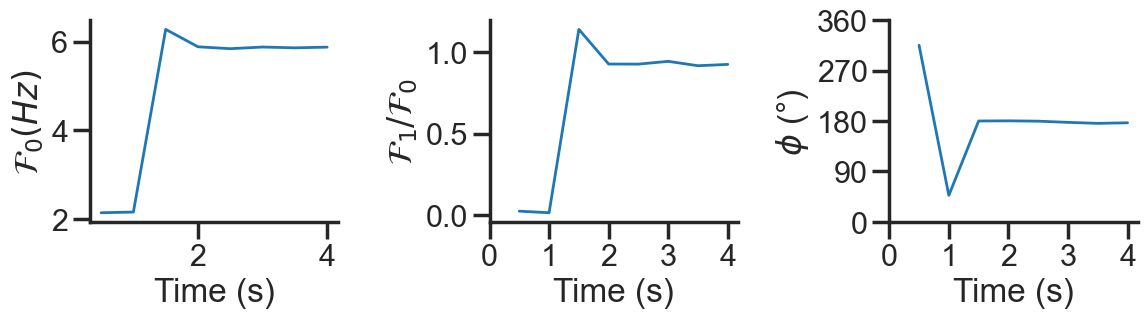

In [1]:
fig, ax = plt.subplots(1, 3, figsize=[2*width, height])

sns.lineplot(data=data, x='time', y='m0', legend=False, lw=2, ax=ax[0])
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('$\mathcal{F}_0 (Hz)$')
ax[1].set_xticks([0, 1, 2, 3, 4])

sns.lineplot(x=data['time'], y=data['m1']/data['m0'], legend=False, lw=2, ax=ax[1])
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('$\mathcal{F}_1 / \mathcal{F}_0$')
ax[1].set_xticks([0, 1, 2, 3, 4])

sns.lineplot(x=data['time'], y=data['phase']*180/np.pi, legend=False, lw=2, ax=ax[2])
ax[2].set_xlabel('Time (s)')
ax[2].set_ylabel('$\phi$ (°)')
ax[2].set_xticks([0, 1, 2, 3, 4])
ax[2].set_yticks([0, 90, 180, 270, 360])
plt.show()

### Multiple trials



#### Simulations



In [1]:
ini_list = np.arange(1, 10)

REPO_PATH = "/home/leon/tmp/rnn_numba"

IF_LOAD_MAT = 0
IF_SAVE_MAT = 1

for ini in ini_list:
    print('##########################################')
    print("trial", ini)
    print('##########################################')

    model = Network('config_bump.yml', 'bump_ini_%d' % ini, REPO_PATH,
                    IF_LOAD_MAT=IF_LOAD_MAT, IF_SAVE_MAT=IF_SAVE_MAT)

    model.run()

    IF_LOAD_MAT = 1
    IF_SAVE_MAT = 0

#+begin_example
  ##########################################
  trial 1
  ##########################################
  Loading config from /home/leon/tmp/rnn_numba/conf/config_bump.yml
  Saving to /home/leon/tmp/rnn_numba/data/simul/bump_ini_1.h5
  Generating matrix Cij
  Saving matrix to /home/leon/tmp/rnn_numba/data/matrix/Cij.npy
  Running simulation
  Elapsed (with compilation) = 7.185097862966359s
  ##########################################
  trial 2
  ##########################################
  Loading config from /home/leon/tmp/rnn_numba/conf/config_bump.yml
  Saving to /home/leon/tmp/rnn_numba/data/simul/bump_ini_2.h5
  Loading matrix from /home/leon/tmp/rnn_numba/data/matrix/Cij.npy
  Running simulation
  Elapsed (with compilation) = 7.146178343042266s
  ##########################################
  trial 3
  ##########################################
  Loading config from /home/leon/tmp/rnn_numba/conf/config_bump.yml
  Saving to /home/leon/tmp/rnn_numba/data/simul/bump_ini_3.

#### Analysis



##### Imports



In [1]:
import pandas as pd
from src.analysis.decode import decode_bump

##### Load data



In [1]:
ini_list = np.arange(1, 10)

df_list = []

for ini in ini_list:
    df_i = pd.read_hdf(REPO_PATH + "/data/simul/bump_ini_%d.h5" % ini, mode="r")
    df_i['trial'] = ini
    df_list.append(df_i)

df = pd.concat(df_list, ignore_index=True)
print(df.head())

rates         ff       h_E  neurons   time  trial
0  2.321475   4.623997 -5.933689        0  0.499      1
1  3.025828  14.550566 -5.934201        1  0.499      1
2  1.687476  -8.390330 -5.934716        2  0.499      1
3  3.935092  13.553052 -5.935232        3  0.499      1
4  1.275855  -3.012375 -5.935751        4  0.499      1

In [1]:
data = df.groupby(['time', 'trial'])['rates'].apply(decode_bump).reset_index()
data[['m0', 'm1', 'phase']] = pd.DataFrame(data['rates'].tolist(), index=data.index)
data = data.drop(columns=['rates'])
print(data.head())

time  trial        m0        m1     phase
0  0.499      1  2.174456  0.086060  1.178232
1  0.499      2  2.196528  0.053862  4.326013
2  0.499      3  2.170244  0.062079  5.561728
3  0.499      4  2.156730  0.047520  4.049448
4  0.499      5  2.194362  0.115558  5.109936

In [1]:
end_point = data[data.time == data.time.iloc[-1]]
print(end_point.head())

time  trial        m0        m1     phase
63  3.999      1  5.890422  5.322490  3.249928
64  3.999      2  5.879518  5.400758  3.053245
65  3.999      3  5.875562  5.396946  3.059773
66  3.999      4  5.905265  5.516230  3.120420
67  3.999      5  5.859009  5.415958  3.339839

##### Phases



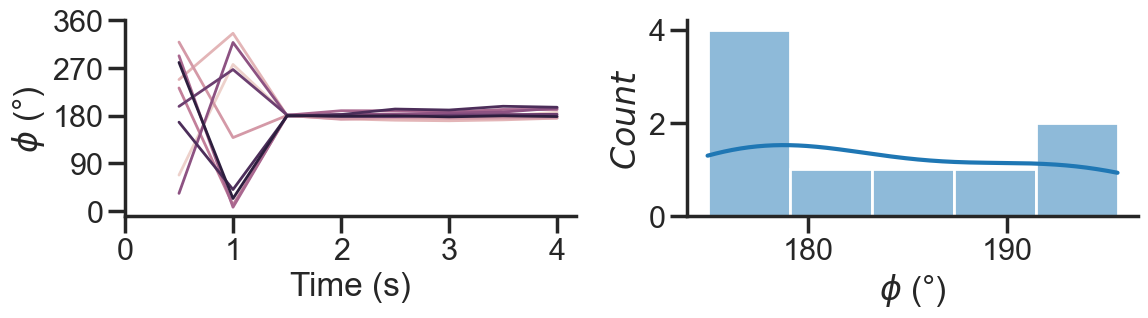

In [1]:
fig, ax = plt.subplots(1, 2, figsize=[2*width, height])

sns.lineplot(data=data, x='time', y=data['phase']*180/np.pi, legend=False, lw=2, ax=ax[0], hue='trial')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('$\phi$ (°)')
ax[0].set_xticks([0, 1, 2, 3, 4])
ax[0].set_yticks([0, 90, 180, 270, 360])

sns.histplot(data=end_point, x=end_point['phase']*180/np.pi, legend=False, ax=ax[1], bins='auto', kde=True)
ax[1].set_xlabel('$\phi$ (°)')
ax[1].set_ylabel('$Count$')
# ax[1].set_xticks([0, 90, 180, 270, 360])
plt.show()

##### Precision Errors



In [1]:
from scipy.stats import circmean
stim_phase = np.pi

end_point['accuracy'] = end_point.phase - stim_phase
end_point['precision'] = end_point.phase - circmean(end_point.phase)
print(end_point.head())

time  trial        m0        m1     phase  accuracy  precision
63  3.999      1  5.890422  5.322490  3.249928  0.108335   0.037898
64  3.999      2  5.879518  5.400758  3.053245 -0.088348  -0.158785
65  3.999      3  5.875562  5.396946  3.059773 -0.081819  -0.152256
66  3.999      4  5.905265  5.516230  3.120420 -0.021173  -0.091609
67  3.999      5  5.859009  5.415958  3.339839  0.198246   0.127809

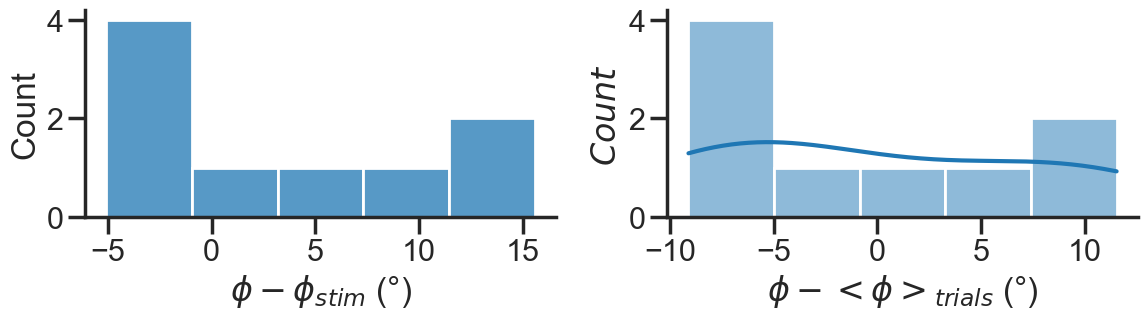

In [1]:
fig, ax = plt.subplots(1, 2, figsize=[2*width, height])

sns.histplot(data=end_point, x=end_point['accuracy']*180/np.pi, legend=False, lw=2, ax=ax[0])
ax[0].set_xlabel('$\phi - \phi_{stim}$ (°)')
ax[0].set_ylabel('Count')

sns.histplot(data=end_point, x=end_point['precision']*180/np.pi, legend=False, ax=ax[1], bins='auto', kde=True)
ax[1].set_xlabel('$\phi - <\phi>_{trials}$ (°)')
ax[1].set_ylabel('$Count$')

plt.show()